In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [3]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [4]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [5]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [6]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [7]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [8]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [9]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        
        if (bidirectional == True):
            self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        else:
            self.gru = nn.GRU(D_in, D_in, batch_first=True)
        
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [10]:
class Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(256, 512)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.2)
        
        self.gru = nn.GRU(H, H, batch_first=True)
        self.attention = ForcedAttentionModule(D_out * 2)
        
        self.fc = nn.Linear(512 * 2, 74)
        self.log_softmax = nn.Softmax(dim=2)

    def forward(self, input_tensor, hidden_tensor, query, pos):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        output_tensor, hidden_tensor = self.gru(output_tensor, hidden_tensor)
        
        context_vector, alpha = self.attention(query, output_tensor, pos)
        output_tensor = torch.cat([output_tensor, context_vector], dim=2)

        output_tensor = self.fc(output_tensor)
        prediction_tensor = self.softmax(output_tensor)

        return prediction_tensor, hidden_tensor, context_vector, alpha

class AdditiveAttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(AdditiveAttentionModule, self).__init__()
        self.fc_alpha = nn.Linear(H, 1)
        self.W = nn.Linear(H, H)
        self.V = nn.Linear(H, H)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        output_tensor = torch.tanh(torch.add(self.W(query), self.V(key)))
        e = self.fc_alpha(output_tensor)
        e_sig = self.sigmoid(e)
        alpha = self.softmax(e_sig).transpose(1, 2)
        
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha
    
            
        alpha_forced = torch.zeros(alpha.shape)
    
class MultiplicativeAttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(MultiplicativeAttentionModule, self).__init__()
        self.Wa = nn.Linear(H, H)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        input_tensor = self.Wa(key)
        output_tensor = torch.bmm(query, input_tensor.transpose(1, 2))
        alpha = self.softmax(output_tensor).transpose(1, 2)
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha
    
class ForcedAttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(ForcedAttentionModule, self).__init__()
        self.Wa = nn.Linear(H, H)
        self.softmax = nn.Softmax(dim=1)
#         self.force_variable = torch.rand(1, requires_grad=True)
        self.force_variable = Variable(torch.tensor(1.0), requires_grad=True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, query, key, pos):
        input_tensor = self.Wa(key)
        output_tensor = torch.bmm(query, input_tensor.transpose(1, 2))
        alpha = self.softmax(output_tensor).transpose(1, 2)
        
        alpha_forced = torch.zeros(alpha.shape).to(device)
        
        if (pos < 5):
            alpha_forced[:, 0, pos:pos + 5] = torch.tensor([5.0, 4.0, 3.0, 2.0 ,1.0]) / 15
            
        elif (pos > alpha.shape[2] - 5):
            alpha_forced[:, 0, pos - 5:pos] = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]) / 15
            
        else:
            alpha_forced[:, 0, pos - 4 : pos + 5] = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 4.0, 3.0, 2.0 ,1.0]) / 25
            
        force_rate = self.sigmoid(self.force_variable).to(device)
        pass_rate = Variable(1 - force_rate).to(device)
        
        alpha = torch.add(pass_rate * alpha, force_rate * alpha_forced)
        
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha

In [11]:
class Encoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
#       self.gru = nn.GRU(H, D_out, bidirectional=True, batch_first=True)
        self.gru_list = nn.ModuleList([ResidualGRU(H) for i in range(2)])
        
    def forward(self, input_tensor):
            
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        for gru in self.gru_list:
            output_tensor = gru(output_tensor)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(512, 512)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.2)
        
#       self.gru = nn.GRU(H, H, batch_first=True)
        self.gru_list = nn.ModuleList([ResidualGRU(H) for i in range(2)])
        
        self.fc = nn.Linear(512, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        for gru in self.gru_list:
            output_tensor = gru(output_tensor)

        output_tensor = self.fc(output_tensor)
        
#         print("Output Tensor Shape: {}".format(output_tensor.shape))
        
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H, D_out).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
#         print(pred_tensor)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
    
net = Mel2SeqNet(80, 512, 256)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [13]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 4
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            batched_tensor[order, :tensor_size_list[order], :] = tensor_list[order]
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [14]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [15]:
preloader = Batched_Preloader(mel_path_list, ground_truth_list, 32)

In [16]:
def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [17]:
preloader.initialize_batch()
tensor_input, ground_truth, loss_mask, length_list = preloader.get_batch()

Loading Error
08-29 20:37:28
Calculated 300 Batches
Loss 300: 0.06338298320770264
08-29 20:40:24
어------------------------------------------------------------------------------------------------------------ᄋ아.<eos>
어아.<eos>
주말에는 보통 집 밖으로 나오지 않아요.<eos>---


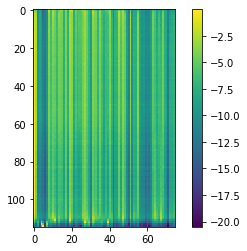

Mean Loss: 0.10784005306382088
----------------------------------------------------
08-29 20:41:26
Calculated 300 Batches
Loss 300: 0.06306319932142894
08-29 20:41:50
저느     -------------------------------------------------------------------------------어다.<eos>
저느 어다.<eos>
모든 도시는 고유한 특성을 지니고 있다.<eos>--


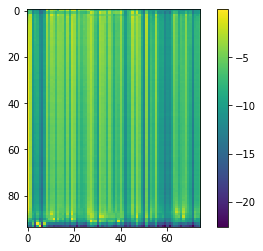

Mean Loss: 0.08657404593860138
----------------------------------------------------
08-29 20:42:01
Calculated 300 Batches
Loss 300: 0.05621925493081411
08-29 20:42:24
어느ᅡ 아 아 아 아 아 아 아--ᅡ--ᅡ--ᅡ--ᅡ--------------------------------------------------------------어아.<eos>
어느ᅡ 아 아 아 아 아 아 아ᅡᅡᅡᅡ어아.<eos>
이 건물은 외부인이 출입할 수 없습니다.<eos>


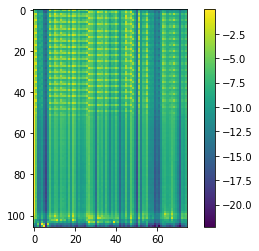

Mean Loss: 0.0872145785304969
----------------------------------------------------
08-29 20:42:34
Calculated 300 Batches
Loss 300: 0.05426010489463806
08-29 20:42:59
아-아-아-아-아-아-아-아-아-아-아-아-아-아 아 아--------------------------------------------------------ᅵ됴.<eos>
아아아아아아아아아아아아아아 아 아ᅵ됴.<eos>
이 아이에게서 예술적 재능이 엿보입니다.<eos>---


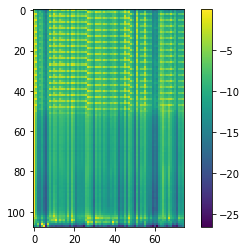

Mean Loss: 0.08237887344830294
----------------------------------------------------
08-29 20:43:10
Calculated 300 Batches
Loss 300: 0.05319940050443014
08-29 20:43:35
으-느----------------------------------------------------------으-아-아-아-아-으-아-아-아-아-아-아-아-이-다-.<eos>
으느으아아아아으아아아아아아아이다.<eos>
올해 들어 범죄가 눈에 띄게 증가했어요.<eos>---


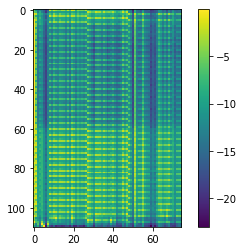

Mean Loss: 0.07803240138493943
----------------------------------------------------
08-29 20:43:46
Calculated 300 Batches
Loss 300: 0.05265503625075022
08-29 20:44:10
아-나----------------------------------------------아-아-아-아-아-아-아-아-아-아-아-아-아-이-다.<eos>
아나아아아아아아아아아아아아아이다.<eos>
아내는 나를 보고 기쁨의 눈물을 흘렸다.<eos>-


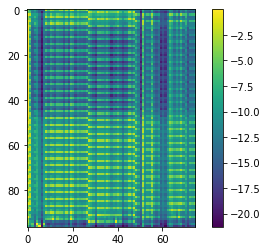

Mean Loss: 0.08228451156371544
----------------------------------------------------
08-29 20:44:21
Calculated 300 Batches
Loss 300: 0.05398840208848318
08-29 20:44:46
아-나-아-아-ᄋ -아-아-ᄋ -ᄋ -ᄋ -아-아-아-아-아-ᄋ--------------------------------------------어-아--.<eos>
아나아아ᄋ 아아ᄋ ᄋ ᄋ 아아아아아ᄋ어아.<eos>
저는 전체적으로 제 전공에 만족합니다.<eos>--


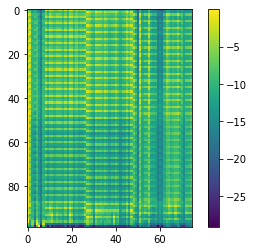

Mean Loss: 0.08089599714789894
----------------------------------------------------
08-29 20:44:57
Calculated 300 Batches
Loss 300: 0.05380631983280182
08-29 20:45:20
아-느-------------------------------------------ᄋ -ᄋ -아-아-아-아-아-아-아-아-아-아-아-아-아-아-아.<eos>
아느ᄋ ᄋ 아아아아아아아아아아아아아아아.<eos>
많은 사람들이 여기에서 죽어서 묻혀 있어.<eos>


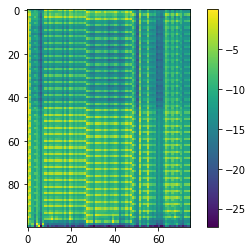

Mean Loss: 0.08247831230028226
----------------------------------------------------
08-29 20:45:31
Calculated 300 Batches
Loss 300: 0.05460010965665182
08-29 20:45:56
으-으-ᄋ -ᄋ -으-으-아-아-아----------------------------------------------------- -아-아-아-아-아-어-요--.<eos>
으으ᄋ ᄋ 으으아아아 아아아아아어요.<eos>
저는 여러 연극에서 조연을 맡았습니다.<eos>--


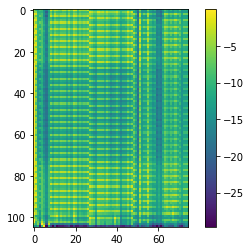

Mean Loss: 0.0847407918800786
----------------------------------------------------
08-29 20:46:07
Calculated 300 Batches
Loss 300: 0.05406091113885244
08-29 20:46:31
가--------------------------------------------------ᅳ-ᄋ -으-으-ᄋ -아-아-아-아-아-아-아-아-아-아-아-어-아--.<eos>
가ᅳᄋ 으으ᄋ 아아아아아아아아아아아어아.<eos>
예전에 어디선가 그 커플을 본 적이 있다.<eos>-


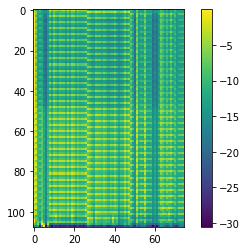

Mean Loss: 0.08324027445299974
----------------------------------------------------
08-29 20:46:41
Calculated 300 Batches
Loss 300: 0.054151917497316994
08-29 20:47:06
어-------------------------------------------------------------------으-ᄋ -으-ᄋ -ᄋ -아-아-아-아-아-아-아-아-아-아-어-요-.<eos>
어으ᄋ 으ᄋ ᄋ 아아아아아아아아아아어요.<eos>
면접에 앞서 간단한 테스트가 있습니다.<eos>--


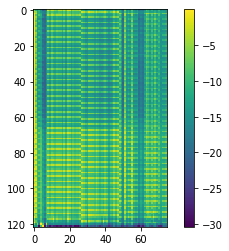

Mean Loss: 0.08171565536460029
----------------------------------------------------
08-29 20:47:16
Calculated 300 Batches
Loss 300: 0.05410460631052653
08-29 20:47:40
ᄌ-----------------------------------------------------------------------------------ᄋ--으-으-아-아-아-아-아-이-아-아-이-이-어-아--.<eos>
ᄌᄋ으으아아아아아이아아이이어아.<eos>
아이스크림이 녹기 전에 얼른 집에 가자.<eos>---


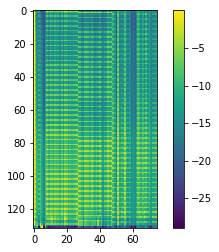

Mean Loss: 0.08599131608550849
----------------------------------------------------
08-29 20:47:51
Calculated 300 Batches
Loss 300: 0.05333762367566427
08-29 20:48:14
아-느----------------------------------------- -ᄋ -ᄋ -ᄋ -ᄋ -ᄋ -아-아-아-아-아-아-아-아-이-어-아-.<eos>
아느 ᄋ ᄋ ᄋ ᄋ ᄋ 아아아아아아아아이어아.<eos>
말씀하시는 것에 어느 정도는 동의합니다.<eos>


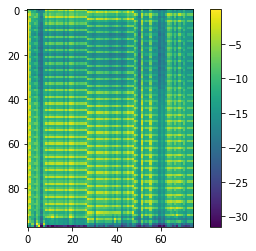

Mean Loss: 0.0823675859975214
----------------------------------------------------
08-29 20:48:25
Calculated 300 Batches
Loss 300: 0.053449819485346474
08-29 20:48:49
어-------------------------------------------------ᄋ--아-아-아-아-아-아-아-아-아 아 아-이-어-아-.<eos>
어ᄋ아아아아아아아아아 아 아이어아.<eos>
현재 주택 수요가 공급에 비해 낮습니다.<eos>---


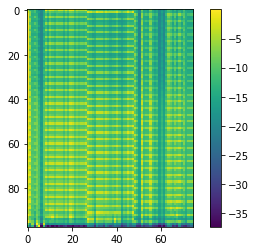

Mean Loss: 0.08786632923734666
----------------------------------------------------
08-29 20:49:00
Calculated 300 Batches
Loss 300: 0.05415286123752594
08-29 20:49:23
어-으----------------------------ᄋ---------------------------ᅳ--------ᅡ-아-아-아-아-아-아-아-아-어-요-.<eos>
어으으ᅡ아아아아아아아아어요.<eos>
나는 춤추는 것보다 노래하는 게 더 좋다.<eos>--


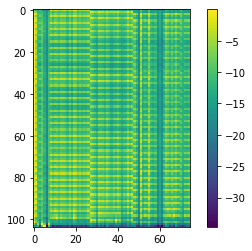

Mean Loss: 0.08266964889971713
----------------------------------------------------
08-29 20:49:33
Calculated 300 Batches
Loss 300: 0.054185872276624046
08-29 20:49:56
어--------------------------------------------------------------ᅳ-으-아-아-아-아-아-아-아-아-아-아-어-아--.<eos>
어ᅳ으아아아아아아아아아아어아.<eos>
저는 어렸을 때 많은 어려움을 겪었어요.<eos>


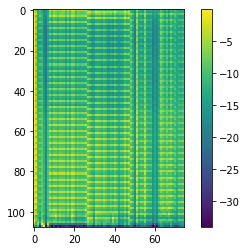

Mean Loss: 0.08204295996066337
----------------------------------------------------
08-29 20:50:07
Calculated 300 Batches
Loss 300: 0.05433318018913269
08-29 20:50:30
아-으-으-으-- -------------------------ᄋ--------아-------아-------ᄋ-----아-------아-아-아-어-요-.<eos>
아으으으 ᄋ아아ᄋ아아아아어요.<eos>
한순간의 부주의가 사고를 불러올 수 있다.<eos>


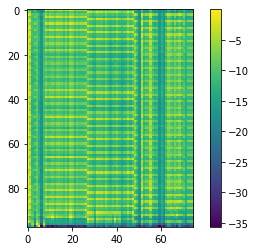

Mean Loss: 0.08506684283929304
----------------------------------------------------
08-29 20:50:40
Calculated 300 Batches
Loss 300: 0.05243475238482157
08-29 20:51:03
어-느--------------------------------------------------ᅳ-으-아-아-아-아-아-아-아-아 아 아-어-요--.<eos>
어느ᅳ으아아아아아아아아 아 아어요.<eos>
최대 이십 학점까지 신청할 수 있습니다.<eos>-


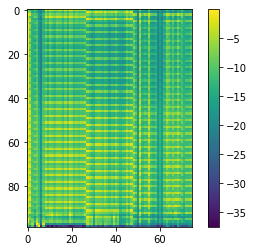

Mean Loss: 0.08076134031383779
----------------------------------------------------
08-29 20:51:14
Calculated 300 Batches
Loss 300: 0.05010618766148885
08-29 20:51:37
아-느----------------------------------------------으--아--아--아--아--아--아--아--아--아--아--아--어--아-.<eos>
아느으아아아아아아아아아아아어아.<eos>
공룡의 멸종에 대해 많은 가설들이 있다.<eos>


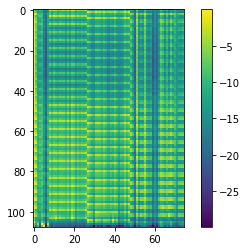

Mean Loss: 0.08100644823693755
----------------------------------------------------
08-29 20:51:48
Calculated 300 Batches
Loss 300: 0.050970966617266335
08-29 20:52:11
ᄋ-ᅳ-느--으--으--으----------------------------------아----------아----------아- 아- 아- 아- 아--아--어--아.<eos>
으느으으으아아아 아 아 아 아아어아.<eos>
이곳은 휴가를 보내기에 이상적인 곳이다.<eos>-


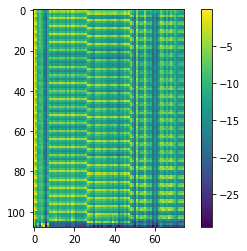

Mean Loss: 0.08070146257791795
----------------------------------------------------
08-29 20:52:21
Calculated 300 Batches
Loss 300: 0.05107152462005615
08-29 20:52:45
아-느--으--아--------------아--ᄋ-----------------------------------아--아--아--아--아--아--어--아.<eos>
아느으아아ᄋ아아아아아아어아.<eos>
농촌의 노동 인구가 점점 줄고 있어요.<eos>---


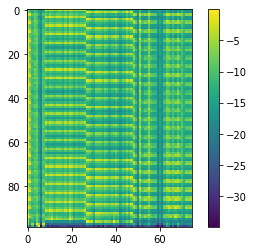

Mean Loss: 0.07684837246656592
----------------------------------------------------
08-29 20:52:56
Calculated 300 Batches
Loss 300: 0.051466276248296104
08-29 20:53:18
으-느------------------------------------------------------------------아--아--아--아--아--아--아--아--아--이--아.<eos>
으느아아아아아아아아아이아.<eos>
일본은 남한 면적의 네 배 정도 된다.<eos>---


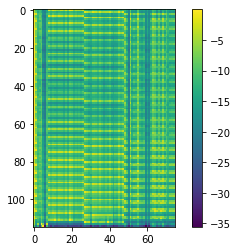

Mean Loss: 0.07763317168511481
----------------------------------------------------
08-29 20:53:28
Calculated 300 Batches
Loss 300: 0.053564553459485374
08-29 20:53:51
아-느-------ᄋ----------ᄋ-----아--ᄋ-----------아--아---------아----아-아------아---아--ᄋ------------어-아-.<eos>
아느ᄋᄋ아ᄋ아아아아아아아ᄋ어아.<eos>
저는 이 분야에 폭넓은 경험이 있습니다.<eos>


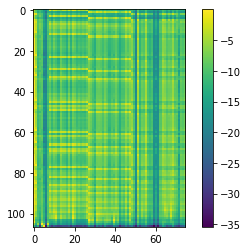

Mean Loss: 0.08151612476758821
----------------------------------------------------
08-29 20:54:02
Calculated 300 Batches
Loss 300: 0.05618204176425934
08-29 20:54:25
어-느--ᄋ----------------------------------------------ᅡ-아------------ᅡ-아------ᅡ-아 아 아 았아-요.<eos>
어느아아ᅡ아ᅡ아 아 아 았아요.<eos>
그 아이는 풍선이 터지자 울음을 터뜨렸다.<eos>


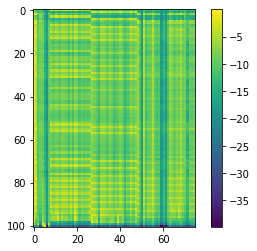

Mean Loss: 0.07935721117856477
----------------------------------------------------
08-29 20:54:36
Calculated 300 Batches
Loss 300: 0.051637103160222374
08-29 20:55:00
아-느------ᅳ----------------ᄋ--------ᄋ--------아-------아---아- -----아- -----아---이--아---.<eos>
아느ᅳᄋᄋ아아아 아 아이아.<eos>
이 제품은 초보자들에게 딱 알맞습니다.<eos>---


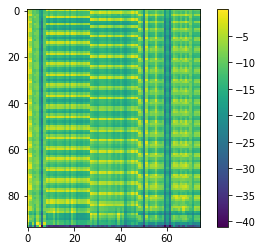

Mean Loss: 0.0796031488968029
----------------------------------------------------
08-29 20:55:11
Calculated 300 Batches
Loss 300: 0.051516552766164146
08-29 20:55:34
어-느-----으--------------------------------------아--------------아--아--아--아--아--아--아--이--요-.<eos>
어느으아아아아아아아아이요.<eos>
그 남자처럼 교양 없는 사람은 처음이야.<eos>-


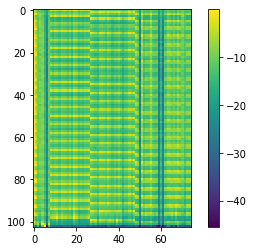

Mean Loss: 0.07966038944525186
----------------------------------------------------
08-29 20:55:44
Calculated 300 Batches
Loss 300: 0.052098204692204796
08-29 20:56:08
아-느-----으-----아- 아-------- -------아------ᄋ----------- 이-----------아--아--아--이--아--.<eos>
아느으아 아 아ᄋ 이아아아이아.<eos>
그녀는 음악에만 전념하기로 결심했다.<eos>--


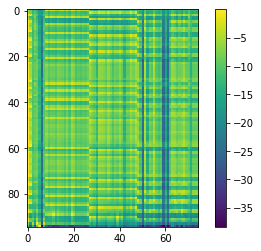

Mean Loss: 0.08112265918693297
----------------------------------------------------
08-29 20:56:19
Calculated 300 Batches
Loss 300: 0.051976035038630165
08-29 20:56:43
아--------------------------------아--------------------------------ᅡ--아--아--아--아--아--아--아--아--어--아.<eos>
아아ᅡ아아아아아아아아어아.<eos>
그들은 내가 시험에 떨어졌다고 알려 왔다.<eos>


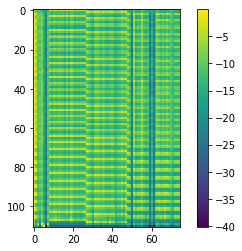

Mean Loss: 0.07851675748429797
----------------------------------------------------
08-29 20:56:54
Calculated 300 Batches
Loss 300: 0.053158516685167946
08-29 20:57:17
어--느-----------아---아------아-------아-----ᄋ--아------아--아-------아-ᄋ---------------------어-아--.<eos>
어느아아아아ᄋ아아아아ᄋ어아.<eos>
나이에 상관없이 누구나 지원할 수 있다.<eos>---


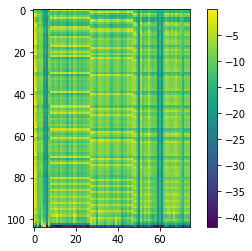

Mean Loss: 0.07819684657836791
----------------------------------------------------
08-29 20:57:28
Calculated 300 Batches
Loss 300: 0.05128555496533712
08-29 20:57:51
으--느---으---으-----아-------아------아-아---아---------아-----ᄋ----이--아---------------------이---어---아---.<eos>
으느으으아아아아아아ᄋ이아이어아.<eos>
대기오염은 많은 나라에서 심각한 문제야.<eos>


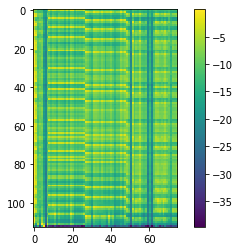

Mean Loss: 0.07447009955398735
----------------------------------------------------


In [18]:
EPOCH = 30
REPEAT = 1

for epoch in range(EPOCH):
    try:
         net.load('model_saved/CTC_Deeper_2')
    except:
        print("Loading Error")
    preloader.initialize_batch()
    counter = 0
    loss_list = list()
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    while preloader.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader.get_batch()
        
        for i in range(REPEAT):
            pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        
        counter += 1
        loss_list.append(loss)
        
        if (counter % 300 == 0):
            print('Calculated {} Batches'.format(counter))
            print('Loss {}: {}'.format(counter, loss))
            print(datetime.now().strftime('%m-%d %H:%M:%S'))

            _, index = pred_tensor[:, 0, :].max(-1)
    
            sentence = tokenizer.num2word(index.view(-1))
            print(''.join(sentence))
            index_ = Decode_CTC_Prediction(index)
            sentence_ = tokenizer.num2word(index_)
            print(''.join(sentence_))
            true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
            print(''.join(true_sentence))
            
            plt.figure()
            plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
            plt.colorbar()
            plt.show()

    net.save('model_saved/CTC_Deeper_2')
    print("Mean Loss: {}".format(np.mean(np.asarray(loss_list))))
    print("----------------------------------------------------")